# New index for `Curve`

In [1]:
import welly
import numpy as np


w = welly.Well.from_las('./P-129_out.LAS')

w

Well(uwi: 'Long = 63* 45'24.460  W', 24 curves: ['CALI', 'HCAL', 'PEF', 'DT', 'DTS', 'DPHI_SAN', 'DPHI_LIM', 'DPHI_DOL', 'NPHI_SAN', 'NPHI_LIM', 'NPHI_DOL', 'RLA5', 'RLA3', 'RLA4', 'RLA1', 'RLA2', 'RXOZ', 'RXO_HRLT', 'RT_HRLT', 'RM_HRLT', 'DRHO', 'RHOB', 'GR', 'SP'])

In [2]:
dt = w.data['DT']

In [3]:
type(dt)

welly.curve.Curve

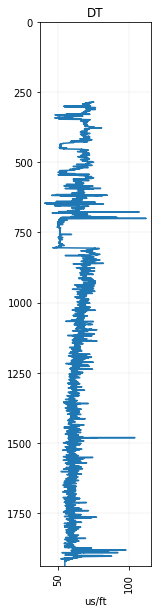

In [4]:
dt.plot()

In [5]:
dt[:3]

Curve([nan, nan, nan])

In [6]:
dt.basis[:3]

array([1.0668, 1.2192, 1.3716])

In [7]:
dt[np.isnan(dt)].shape

(1868,)

In [8]:
dt.shape

(12718,)

In [9]:
dt

Curve([nan, nan, nan, ..., nan, nan, nan])

In [10]:
dt._read_at(1000)

64.22763560141377

In [11]:
dt[999:1001]

Curve([nan, nan])

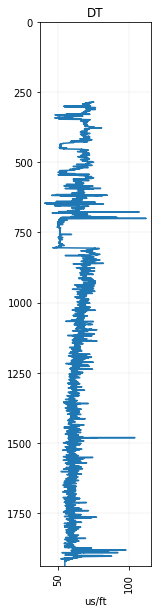

In [12]:
dt.plot()

In [13]:
dt.iloc[10000:10050]

AttributeError: 'Curve' object has no attribute 'iloc'

## Ways to generate a basis

In [14]:
import numpy as np
data = np.random.random(10000)

start = 20
step = 0.1524

In [15]:
# list comprehension`
%timeit [start + step*r for r in range(data.shape[-1])]
idx = [start + step*r for r in range(data.shape[-1])]

698 µs ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
# Generator
def get_basis(start, step):
    i = 0
    while True:
        yield start + i*step
        i += 1

#%timeit dict(zip(get_basis(start, step), data))

In [17]:
# numpy
%timeit start + step * np.arange(data.shape[-1])
idx = start + step * np.arange(data.shape[-1])

26.3 µs ± 2.86 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Cast as `xr.DataArray`

In [18]:
data = dt.values
idx = dt.basis

In [19]:
import xarray as xr

d = xr.DataArray(data, coords=[idx], dims=['depth'], name='DT')

/home/matt/anaconda3/envs/geocomp/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [20]:
d

<xarray.DataArray 'DT' (depth: 12718)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * depth    (depth) float64 1.067 1.219 1.372 ... 1.939e+03 1.939e+03 1.939e+03

In [21]:
d.values

array([nan, nan, nan, ..., nan, nan, nan])

In [62]:
d[101]

<xarray.DataArray 'DT' ()>
array(nan)
Coordinates:
    depth    float64 16.46

In [78]:
d[10000:10010].coords.values()

ValuesView(Coordinates:
  * depth    (depth) float64 1.525e+03 1.525e+03 ... 1.526e+03 1.526e+03)

In [104]:
d.loc[1500.2256]

KeyError: 1500.2256

In [109]:
d.coords['depth'].values

array([1.0668000e+00, 1.2192000e+00, 1.3716000e+00, ..., 1.9388328e+03,
       1.9389852e+03, 1.9391376e+03])

In [98]:
d.loc[1500:1505].coords['depth']

<xarray.DataArray 'depth' (depth: 33)>
array([1500.0732, 1500.2256, 1500.378 , 1500.5304, 1500.6828, 1500.8352,
       1500.9876, 1501.14  , 1501.2924, 1501.4448, 1501.5972, 1501.7496,
       1501.902 , 1502.0544, 1502.2068, 1502.3592, 1502.5116, 1502.664 ,
       1502.8164, 1502.9688, 1503.1212, 1503.2736, 1503.426 , 1503.5784,
       1503.7308, 1503.8832, 1504.0356, 1504.188 , 1504.3404, 1504.4928,
       1504.6452, 1504.7976, 1504.95  ])
Coordinates:
  * depth    (depth) float64 1.5e+03 1.5e+03 1.5e+03 ... 1.505e+03 1.505e+03

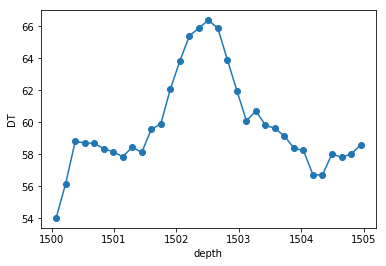

In [84]:
d.loc[1500:1505].plot(marker='o')

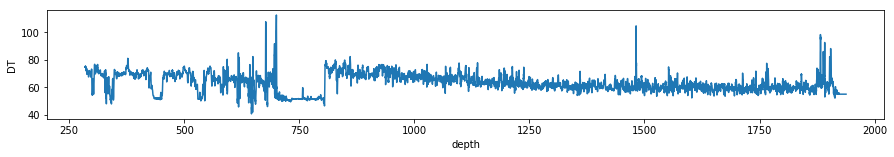

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15,2))
d.plot()

## Subclass `xarray`

In [41]:
# Standard way to subclass...
import xarray as xr

class Curve(xr.DataArray):

    def __init__(self, data, basis=None, params=None, name=None, *args, **kwargs):

        # Cannot use self until after call to `super()`.
        if basis is None:
            start = params.get('start', 0)
            step = params.get('step', 1)
            basis = [start + i*step for i in range(data.shape[-1])]

        if params is None:
            params = {}
        
        mnemonic = params.get('mnemonic', None)
        domain = params.get('domain', 'depth')

        super(Curve, self).__init__(data, coords=[basis], dims=[domain])

        # Now can use self.
        self['start'] = basis[0]
        self['step'] = basis[1] - basis[0]

        if params is None:
            params = {}
        self['mnemonic'] = mnemonic
        self['units'] = params.get('units', None)
        self['run'] = params.get('run', 0)
        self['null'] = params.get('null', -999.25)
        self['service_company'] = params.get('service_company', None)
        self['date'] = params.get('date', None)
        self['code'] = params.get('code', None)

        return

In [42]:
c = Curve(data, basis=idx)

In [43]:
c

TypeError: variable 'depth' has invalid type <class 'collections.OrderedDict'>

## Start and stop ranges etc.

In [15]:
new_start = 2
new_stop = 12
new_step = 1

steps = 1 + (new_stop - new_start) / new_step
new_basis = np.linspace(new_start, new_stop, int(steps), endpoint=True)

new_basis

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [16]:
self = [  np.nan,  np.nan, 8, 5, 4, 1, 3, np.nan, 7, 9, 5, 4, 3,  np.nan,  np.nan,  np.nan,  np.nan,  np.nan]
basis = np.arange(len(self))
nans = np.isnan()

ValueError: invalid number of arguments

In [17]:
from scipy.interpolate import interp1d
interp = interp1d(basis, np.nan_to_num(self),
              bounds_error=True,
              fill_value=np.nan)

In [18]:
interp(new_basis)

array([8., 5., 4., 1., 3., 0., 7., 9., 5., 4., 3.])

In [19]:
dtx = dt[:9681]

In [20]:
dtx[-5:]

Curve([241.8586, 241.8586, 241.8586, 241.8586, 241.8586])

In [21]:
dtt.basis

array([4678.9848, 4679.1372, 4679.2896, ..., 5869.686 , 5869.8384,
       5869.9908])

In [22]:
np.array(dtt[-10:])

array([241.8586, 241.8586, 241.8586, 241.8586, 241.8586, 241.8586,
       241.8586, 241.8586, 241.8586, 241.8586])

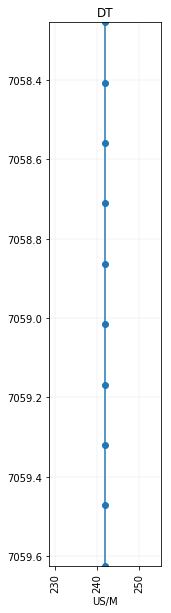

In [23]:
dtt[-10:].plot(marker='o')

## Xarray

In [22]:
import numpy as np
import xarray as xr

In [42]:
xdata = xr.DataArray(np.array(values), dims=['MD'], coords={'MD': md})
xdata

<xarray.DataArray (MD: 13)>
array([3, 9, 5, 4, 3, 4, 4, 4, 3, 8, 5, 6, 7])
Coordinates:
  * MD       (MD) int64 100 101 102 103 104 105 106 107 108 109 110 111 112

### Multi-dimensional index, try 1

In [230]:
data = [3,9,5,4,3,4,4,4,3,8,5,6,7,]
md = np.arange(len(values)) + 100
tvd = np.arange(len(values))**1.05 + 50

In [231]:
md, tvd

(array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112]),
 array([50.        , 51.        , 52.07052985, 53.16940193, 54.28709385,
        55.41899193, 56.56234129, 57.71530221, 58.87655578, 60.04510857,
        61.22018454, 62.40116025, 63.5875235 ]))

In [233]:
xmd = xr.DataArray(md, name='MD', dims=['TVD'], coords={'TVD': tvd})
xdata = xr.DataArray(data, name='data', dims=['MD'], coords={'MD': xmd})

### Multi-dimensional index, try 2

In [199]:
data = np.array([3,9,5,4,3,4,4,4,3,8,5,6,7,])
md = np.arange(len(values)) + 100
tvd = np.arange(len(values))**1.05 + 50
depth = np.stack([md, tvd]).T

xdata = xr.DataArray(data, name='data', dims=['MD'], coords={'MD':md})

In [200]:
xdata['TVD'] = ('MD', tvd)

In [201]:
xdata

<xarray.DataArray 'data' (MD: 13)>
array([3, 9, 5, 4, 3, 4, 4, 4, 3, 8, 5, 6, 7])
Coordinates:
  * MD       (MD) int64 100 101 102 103 104 105 106 107 108 109 110 111 112
    TVD      (MD) float64 50.0 51.0 52.07 53.17 54.29 ... 60.05 61.22 62.4 63.59

In [202]:
xdata.interp(MD=102.5)

<xarray.DataArray 'data' ()>
array(4.5)
Coordinates:
    TVD      float64 52.62
    MD       float64 102.5

In [203]:
xdata.interp(TVD=52.5)

ValueError: dimensions ['TVD'] do not exist

### Swap dims

In [204]:
xdata = xdata.coords['MD'].swap_dims({'MD': 'TVD', })

In [202]:
xdata.interp(MD=102.5)

<xarray.DataArray 'data' ()>
array(4.5)
Coordinates:
    TVD      float64 52.62
    MD       float64 102.5

In [203]:
xdata.interp(TVD=52.5)

ValueError: dimensions ['TVD'] do not exist

### MultiIndex

In [207]:
xdata = xdata.set_index({'depth':['MD','TVD']})
xdata

/home/matt/anaconda3/envs/geocomp/lib/python3.7/site-packages/xarray/core/dataset.py:167: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  idx = pd.MultiIndex(labels=labels, levels=levels, names=names)


<xarray.DataArray 'MD' (TVD: 13)>
array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112])
Coordinates:
  * depth    (depth) MultiIndex
  - MD       (depth) int64 100 101 102 103 104 105 106 107 108 109 110 111 112
  - TVD      (depth) float64 50.0 51.0 52.07 53.17 ... 60.05 61.22 62.4 63.59
Dimensions without coordinates: TVD

In [229]:
xdata.interp(depth=101)

<xarray.DataArray 'MD' (TVD: 13)>
array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112])
Coordinates:
    depth    int64 101
Dimensions without coordinates: TVD

In [225]:
xdata.interp(TVD=52.5)

<xarray.DataArray 'MD' ()>
array(nan)
Coordinates:
  * depth    (depth) MultiIndex
  - MD       (depth) int64 100 101 102 103 104 105 106 107 108 109 110 111 112
  - TVD      (depth) float64 50.0 51.0 52.07 53.17 ... 60.05 61.22 62.4 63.59
    TVD      float64 52.5

In [226]:
xdata.interp(MD=102.5)

ValueError: dimensions ['MD'] do not exist

## Wrap `xarray`

In [55]:
import xarray as xr

class Curve(object):

    def __init__(self, data, basis=None, params=None):

        if basis is None:
            start = params.get('start', 0)
            step = params.get('step', 1)
            basis = [start + i*step for i in range(data.shape[-1])]

        if params is None:
            params = {}
        
        self.start = basis[0]
        self.step = basis[1] - basis[0]
        self.mnemonic = params.get('mnemonic', None)
        self.domain = params.get('domain', 'depth')
        self.units = params.get('units', None)
        self.run = params.get('run', 0)
        self.null = params.get('null', -999.25)
        self.service_company = params.get('service_company', None)
        self.date = params.get('date', None)
        self.code = params.get('code', None)

        self._xarray = xr.DataArray(data, coords=[basis], dims=[self.domain], name=self.mnemonic)

        return
    
# Use getattr to pass-through xarray methods

In [56]:
c = Curve(data, params={'start': 20, 'step': 0.1524})

In [57]:
c